# Generate Input Data

In [ ]:
import numpy as np
import pandas as pd
import random
#Generate 5 random numbers between 10 and 30
np.random.seed(0)
n_samples=1000
n_features = 5
df_XY=pd.DataFrame(data = np.random.normal(0,1, size=(n_samples, n_features)), columns = ['A','B','C','D','E'])
df_XY['Y']=list(np.random.randint(2, size=n_samples))
df_XY['YY']=list(np.random.randint(2, size=n_samples))
df_XY

##############################################################   
df_XY.shape
df_XY.head()
df_XY.to_csv('df_XY.csv',index=False)
##############################################################

In [ ]:
df_XY

,A,B,C,D,E,Y,YY
0,1.764052,0.400157,0.978738,2.240893,1.867558,1,1
1,-0.977278,0.950088,-0.151357,-0.103219,0.410599,0,0
2,0.144044,1.454274,0.761038,0.121675,0.443863,0,0
3,0.333674,1.494079,-0.205158,0.313068,-0.854096,1,0
4,-2.552990,0.653619,0.864436,-0.742165,2.269755,0,1
...,...,...,...,...,...,...,...
995,1.711489,-1.820816,0.163495,-0.813117,-0.605355,0,0
996,-1.327524,-0.644172,1.908883,-0.563545,1.082473,1,0
997,-1.951911,2.441216,-0.017285,0.912282,1.239658,1,1
998,-0.573367,0.424889,-0.271260,-0.683568,-1.537438,1,1


# Download CI-VAE, other necessary packages and Load Packages

In [ ]:
! rm -r ci_vae
! rm bb.pt
! rm bb_residuals.pkl
! rm df_reconstructed.csv
! rm df_reconstructed_decoder.csv
! rm residuals.pdf
! rm results_dict.pkl
! rm df_latent.csv

In [ ]:
! git clone https://github.com/monabiyan/ci_vae.git
! pip install umap-learn

In [ ]:
from ci_vae import ivae
import pandas as pd
import numpy as np
import sklearn
import torch
import umap
import pickle
import matplotlib.pyplot as plt

# Set Necessary Parameters 

In [ ]:
model_init=True
model_tobe_trained=True
save_address="bb"

kl_coef = 0.0001
reconst_coef = 1
classifier_coef = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# Initialize the Model

In [ ]:
obj1 = ivae.IVAE(df_XY = df_XY,
               latent_size = 10,
               reconst_coef = reconst_coef,
               kl_coef = kl_coef,
               classifier_coef = classifier_coef,
               test_ratio = 1)

if model_init:
    obj1.model_initialiaze()

## See The Model Architecture

In [42]:
print(obj1.model)

IVAE_ARCH(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (15): Dropout(p=0.05, inplace=False)
    (16): Linear(in_features=20, out_features=20, bias=True)
    (17): ReLU()
    (18): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=Tru

## See the Initialized Weights

In [ ]:
for param in obj1.model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.3683,  0.2940,  0.3528, -0.3260,  0.0895],
        [-0.1003, -0.1848, -0.2169,  0.0290, -0.1906],
        [-0.1672, -0.4159,  0.1519, -0.3817, -0.3802],
        [-0.0471,  0.2936, -0.3182,  0.1530,  0.4344],
        [ 0.1491, -0.3357,  0.3704,  0.1110,  0.3770],
        [-0.0893,  0.4222, -0.0696, -0.3178,  0.1141],
        [-0.4415, -0.1713,  0.4410, -0.1320, -0.3444],
        [ 0.4396, -0.3588, -0.0510,  0.0754,  0.3654],
        [ 0.0474,  0.2674,  0.2648, -0.2333, -0.2513],
        [ 0.0739,  0.0178, -0.1092, -0.3489, -0.0407],
        [ 0.1091, -0.0034,  0.2146,  0.2415,  0.1675],
        [ 0.0505, -0.1881,  0.4014, -0.1241,  0.1683],
        [-0.0709, -0.0622,  0.1595, -0.2409, -0.1188],
        [-0.0177, -0.3116, -0.1057,  0.1803, -0.1321],
        [-0.1924, -0.3678, -0.2853,  0.3709, -0.3091],
        [ 0.1532,  0.4179,  0.4449, -0.3101, -0.3072],
        [-0.2169,  0.3429, -0.2322,  0.3261,  0.3762],
        [ 0.3307,  0.3839, -0.2585, -0.1963

# RUN for Training

In [ ]:
##########
if model_tobe_trained:
    lr=1e-2
    print(lr)
    obj1.model_training(epochs=100,learning_rate=lr)

    lr=1e-3
    print(lr)
    #obj.model_training(epochs=70,learning_rate=lr)

    lr=1e-3
    print(lr)
    #obj.model_training(epochs=200,learning_rate=lr)

    obj1.model_save(address=save_address+".pt")
    obj1.save_residuals(address=save_address+'_residuals.pkl')
    lr=1e-3
    print(lr)
    #obj.model_training(epochs=70,learning_rate=lr)

    lr=5e-4
    print(lr)
    obj1.model_training(epochs=50,learning_rate=lr)

    obj1.model_save(address=save_address+".pt")
    obj1.save_residuals(address=save_address+'_residuals.pkl')

    lr=1e-5
    print(lr)
    obj1.model_training(epochs=50,learning_rate=lr)

    lr=5e-6
    print(lr)
    obj1.model_training(epochs=50,learning_rate=lr)


# Save The Trained Model

In [ ]:
##########
print("running the neural network")
#run(obj1,save_address)
obj1.model_save(address=save_address+".pt")
obj1.save_residuals(address=save_address+'_residuals.pkl')

running the neural network


# Visualize Residuals

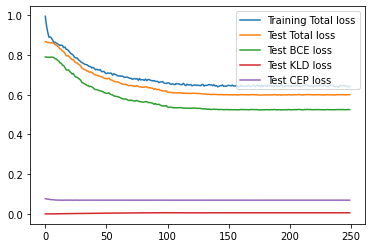

<Figure size 432x288 with 0 Axes>

In [ ]:
obj1.plot_residuals(init_index=0)

# Load Model and Data

In [ ]:
from ci_vae import ivae
import pandas as pd
import numpy as np
import sklearn
import torch
import umap
import pickle
import matplotlib.pyplot as plt

In [ ]:
print("start of the code")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##############################################################   
##############################################################
model_init=True
model_tobe_trained=False

model_init=True
model_file_address='./bb.pt'
save_address1="./"

df_XY=pd.read_csv('df_XY.csv')

start of the code


## Load Saved Model

In [ ]:
obj1 = ivae.IVAE(df_XY = df_XY,
               reconst_coef = reconst_coef,
               latent_size = 10,
               kl_coef = kl_coef,
               classifier_coef = classifier_coef,
               test_ratio = 1)

obj1.model_initialiaze()

obj1.model_load(address="bb.pt")

## Print the Weights

In [ ]:
for param in obj1.model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.5286,  0.2656,  0.2265, -0.3107, -0.1075],
        [-0.0530, -0.3020, -0.1666,  0.0335, -0.1973],
        [-0.2071, -0.4654,  0.1543, -0.4409, -0.3446],
        [-0.0249,  0.1449, -0.3138,  0.3571,  0.5386],
        [ 0.0585, -0.4035,  0.3729,  0.1902,  0.4101],
        [ 0.0125,  0.4105, -0.1183, -0.4094,  0.0918],
        [-0.4642, -0.2652,  0.3879,  0.0352, -0.3981],
        [ 0.0347, -0.6553, -0.1488,  0.1604,  0.1324],
        [ 0.0810,  0.2524,  0.3310, -0.3315, -0.2017],
        [-0.0557, -0.0976, -0.1734, -0.3872,  0.0213],
        [ 0.0507,  0.1216,  0.2619,  0.2113,  0.2698],
        [ 0.0756, -0.1819,  0.4935, -0.1377,  0.0809],
        [-0.0970, -0.0893,  0.0415, -0.2892,  0.0773],
        [-0.0035, -0.3946, -0.1775,  0.2039, -0.0521],
        [-0.2787, -0.4939, -0.3357,  0.3507, -0.1812],
        [ 0.1911,  0.5907,  0.3620, -0.1770, -0.1848],
        [-0.1214,  0.3281, -0.1209,  0.5248,  0.2381],
        [ 0.2778,  0.2591, -0.3563, -0.1746

# Make Prediction of All Test Data

In [ ]:
with torch.no_grad():
    obj1.model.eval()

    #obj1.load_residuals(address='bb_residuals.pkl')
    print("model loaded")
    
    obj1.generate_test_results()
    print("test data generated")

model loaded
test data generated


# Comprehensive Checking of The Prediction Values vs. True Values. 

In [ ]:
print(obj1.x_last)

tensor([[ 1.7641,  0.4002,  0.9787,  2.2409,  1.8676],
        [-0.9773,  0.9501, -0.1514, -0.1032,  0.4106],
        [ 0.1440,  1.4543,  0.7610,  0.1217,  0.4439],
        ...,
        [-1.9519,  2.4412, -0.0173,  0.9123,  1.2397],
        [-0.5734,  0.4249, -0.2713, -0.6836, -1.5374],
        [-0.1014,  0.7467,  0.9292,  0.2294,  0.4144]])


In [ ]:
print(obj1.x_pred)

tensor([[-0.1195,  0.8545,  0.1786,  0.9621,  0.5868],
        [ 0.0317,  0.4277,  0.8424, -0.1630, -0.1285],
        [-0.1462,  0.4293,  0.9586,  0.3392,  0.5705],
        ...,
        [-0.1468,  1.1007, -0.0386,  1.0630,  0.5283],
        [ 0.2889,  0.8272,  0.2787, -0.6000, -0.6828],
        [-0.1729,  0.3377,  1.0495,  0.2666,  0.5503]])


In [ ]:
(np.abs(obj1.x_pred - obj1.x_last)).mean()

tensor(0.5232)

In [ ]:
(obj1.x_pred-obj1.x_last)

tensor([[-1.8836,  0.4543, -0.8002, -1.2788, -1.2808],
        [ 1.0090, -0.5224,  0.9938, -0.0598, -0.5391],
        [-0.2903, -1.0250,  0.1976,  0.2175,  0.1267],
        ...,
        [ 1.8052, -1.3405, -0.0213,  0.1507, -0.7113],
        [ 0.8622,  0.4023,  0.5499,  0.0836,  0.8546],
        [-0.0715, -0.4090,  0.1204,  0.0371,  0.1359]])

In [ ]:
print(obj1.y_last)

tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,

In [ ]:
print(obj1.y_pred)

tensor([[-0.0025,  0.0060],
        [-0.0076,  0.0094],
        [-0.0257,  0.0075],
        ...,
        [-0.0230,  0.0058],
        [-0.0039,  0.0029],
        [-0.0269,  0.0264]])


In [ ]:
df_XY

,A,B,C,D,E,Y,YY
0,1.764052,0.400157,0.978738,2.240893,1.867558,1,1
1,-0.977278,0.950088,-0.151357,-0.103219,0.410599,0,0
2,0.144044,1.454274,0.761038,0.121675,0.443863,0,0
3,0.333674,1.494079,-0.205158,0.313068,-0.854096,1,0
4,-2.552990,0.653619,0.864436,-0.742165,2.269755,0,1
...,...,...,...,...,...,...,...
995,1.711489,-1.820816,0.163495,-0.813117,-0.605355,0,0
996,-1.327524,-0.644172,1.908883,-0.563545,1.082473,1,0
997,-1.951911,2.441216,-0.017285,0.912282,1.239658,1,1
998,-0.573367,0.424889,-0.271260,-0.683568,-1.537438,1,1


In [ ]:
with torch.no_grad():
    obj1.model.eval()
    for x, y in obj1.testloader:
      x = x.to(device)
      print(x.size())
      print(x)
      # forward
      x_hat,y_hat, mu, logvar,z = obj1.model(x)
    
    df_reconstructed = pd.DataFrame(x_hat.cpu().detach().numpy(), columns=obj1.df_XY.drop(columns=['Y']).columns)
    print(df_reconstructed.shape)
    df_latent=pd.DataFrame(z.cpu().detach().numpy())
    
    obj1.model.eval()
    
    df_reconstructed_decoder=pd.DataFrame(obj1.model.decoder(z).cpu().detach().numpy(), columns=obj1.df_XY.drop(columns=['Y']).columns)

    df_reconstructed.to_csv('df_reconstructed.csv')
    df_latent.to_csv('df_latent.csv')
    df_reconstructed_decoder.to_csv('df_reconstructed_decoder.csv')
    print("Full_data_reconstructed...")
    
    print("========df_reconstructed========")
    print(df_reconstructed)
    print("========df_reconstructed_decoder========")
    print(df_reconstructed_decoder)
    print("========df_Original========")
    print(df_XY)
    
    
    


torch.Size([1000, 5])
tensor([[ 1.7641,  0.4002,  0.9787,  2.2409,  1.8676],
        [-0.9773,  0.9501, -0.1514, -0.1032,  0.4106],
        [ 0.1440,  1.4543,  0.7610,  0.1217,  0.4439],
        ...,
        [-1.9519,  2.4412, -0.0173,  0.9123,  1.2397],
        [-0.5734,  0.4249, -0.2713, -0.6836, -1.5374],
        [-0.1014,  0.7467,  0.9292,  0.2294,  0.4144]])
(1000, 5)
Full_data_reconstructed...
========df_reconstructed========
            A         B         C         D         E
0   -0.111301  0.792058  0.160255  1.020171  0.590423
1    0.061387  0.404288  0.787693 -0.253531 -0.202077
2   -0.099822  0.717460  0.622173  0.571441  0.581744
3    0.438743  0.708463  0.177681  0.012995 -1.208439
4   -0.356933 -0.343012  1.274014 -0.235667  0.271257
..        ...       ...       ...       ...       ...
995 -0.494402 -0.855369 -0.410923 -0.404760 -0.098695
996 -0.369112 -0.506523  1.144517 -0.513514  0.119304
997 -0.145296  1.099658 -0.027158  1.050817  0.524641
998  0.293616  0.954517 

# Checking Linear Separability of Data on Lower Dimensioanl Space

In [ ]:
print("regression analysis")
obj1.regression_analysis(obj1.zs,df_XY['Y'])

regression analysis
0.51


# Visualize Data on Lower Dimensional Space

In [ ]:
print("calculate tsne_umap_pca")
tsne_mat,umap_mat,pca_mat,Y=obj1.calculate_lower_dimensions(obj1.zs,obj1.y_last,N=100)
obj1.plot_lower_dimension(tsne_mat,Y,projection='3d',save_str='tsne3d.pdf')
obj1.plot_lower_dimension(tsne_mat,Y,projection='2d',save_str='tsne2d.pdf')
obj1.plot_lower_dimension(umap_mat,Y,projection='3d',save_str='umap3d.pdf')
obj1.plot_lower_dimension(umap_mat,Y,projection='2d',save_str='umap2d.pdf')
obj1.plot_lower_dimension(pca_mat,Y,projection='3d',save_str='pca3d.pdf')
obj1.plot_lower_dimension(pca_mat,Y,projection='2d',save_str='pca2d.pdf')

print("finished")


# Perform Interpolation across all groups (Y) and all features from YY=0 to YY=1

In [ ]:
ff = obj1.traversal_all_groups(traversal_step=5)

0
254 249
[[-0.15810389 -0.02843587 -0.06276759  0.02361863  0.12825558]
 [-0.14995419 -0.05691716  0.08516241 -0.088661    0.10060047]
 [-0.15093356  0.01527496  0.18113556 -0.09647714  0.07186309]
 [-0.1525566  -0.06614011  0.14290413 -0.14562798  0.07917659]
 [-0.14466314 -0.10864282  0.03233287 -0.1578867   0.09146039]]
1
241 256
[[-0.14874058  0.08618792  0.10231537 -0.02405781  0.09168516]
 [-0.14947717  0.01543538  0.19823042 -0.14172477  0.09033377]
 [-0.15072706  0.03649382  0.20554664 -0.18834753  0.08158787]
 [-0.17862054 -0.06242696  0.10981257 -0.24647301  0.09058829]
 [-0.18417552 -0.04119573 -0.05703061 -0.23941074  0.09742999]]


# See the interpolation results

In [ ]:
with open('results_dict.pkl', 'rb') as f:
    ff = pickle.load(f)

In [ ]:
ff['med']['0']

,A,B,C,D,E
0,-0.116574,0.054407,0.013888,0.027511,0.035203
1,-0.126531,0.011400,0.118662,-0.037375,0.039042
2,-0.115669,-0.024347,0.196449,-0.070320,0.003606
3,-0.111683,-0.030690,0.168314,-0.085981,-0.017066
4,-0.088968,0.011824,0.061215,-0.057050,-0.040057


In [ ]:
ff['mean']['1']

,A,B,C,D,E
0,-0.148741,0.086188,0.102315,-0.024058,0.091685
1,-0.149477,0.015435,0.198230,-0.141725,0.090334
2,-0.150727,0.036494,0.205547,-0.188348,0.081588
3,-0.178621,-0.062427,0.109813,-0.246473,0.090588
4,-0.184176,-0.041196,-0.057031,-0.239411,0.097430


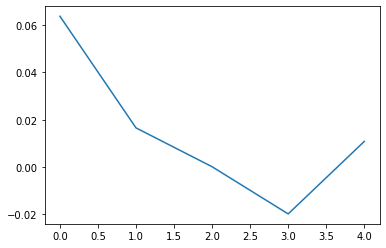

In [ ]:
plt.plot(ff['med']['1']['B'])

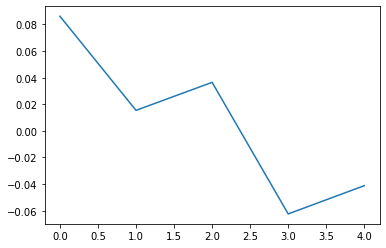

In [ ]:
plt.plot(ff['mean']['1']['B'])

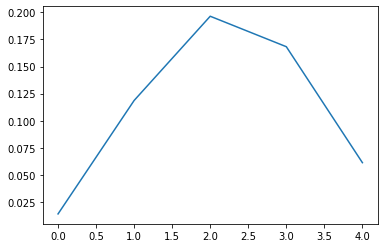

In [ ]:
plt.plot(ff['med']['0']['C'])

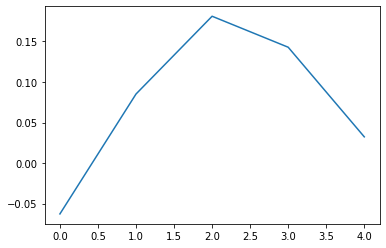

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ff['mean']['0']['C'])

# Generate Synthetic Data for a Given Class

In [ ]:
bb = obj1.synthetic_single_group(group_id=0,nr_of_synthetic=1000)

503 503


In [ ]:
bb.shape

(1000, 5)

In [ ]:
bb

array([[-0.38435403, -0.57587492,  1.01870036, -0.61208028,  0.09112425],
       [-0.39237058, -0.59848094,  0.97522092, -0.63187814,  0.08790676],
       [-0.39906806, -0.61783099,  0.93736935, -0.64955574,  0.0852568 ],
       ...,
       [ 0.236471  ,  0.40151921,  0.25338972, -0.00680118, -0.70889097],
       [ 0.29134449,  0.37699905,  0.15195191,  0.06153865, -0.78167057],
       [ 0.33644342,  0.38028798,  0.09573825,  0.10933591, -0.84602231]])